In [1]:
%load_ext autoreload
%autoreload 2

# Set up
*   Install libraries
*   Load dataset

In [ ]:
! pip install terratorch

In [3]:
# ! mkdir -p dataset

In [ ]:
# ! wget https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/train.zip -P dataset
# ! unzip -q dataset/train.zip -d dataset
# ! rm dataset/train.zip

In [ ]:
# ! wget https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/test.zip -P dataset
# ! unzip -q dataset/test.zip -d dataset
# ! rm dataset/test.zip

In [8]:
# # If you want to run at Google Colab, upload libaray.zip and unzip it.
# ! unzip -q library.zip

In [10]:
# ! rm -rf dataset/__MACOSX
# ! rm -rf __MACOSX

# Segmentation Models PyTorch Factory

You can use the `SMPModelFactory` to initialize segmentation tasks in TerraTorch. Note that not all models support more than 3 channels (e.g., MiT models).

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
from segmentation_models_pytorch.encoders import encoders as smp_encoders
print(f'Available SMP backbones: \n{", ".join(smp_encoders)}')

Available SMP backbones: 
resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x4d, resnext101_32x8d, resnext101_32x16d, resnext101_32x32d, resnext101_32x48d, dpn68, dpn68b, dpn92, dpn98, dpn107, dpn131, vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, senet154, se_resnet50, se_resnet101, se_resnet152, se_resnext50_32x4d, se_resnext101_32x4d, densenet121, densenet169, densenet201, densenet161, inceptionresnetv2, inceptionv4, efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7, mobilenet_v2, xception, timm-efficientnet-b0, timm-efficientnet-b1, timm-efficientnet-b2, timm-efficientnet-b3, timm-efficientnet-b4, timm-efficientnet-b5, timm-efficientnet-b6, timm-efficientnet-b7, timm-efficientnet-b8, timm-efficientnet-l2, timm-tf_efficientnet_lite0, timm-tf_efficientnet_lite1, timm-tf_efficientnet_lite2, timm-tf_efficientnet_lite3, timm-tf_efficientnet_lite4, tim

In [3]:
from terratorch.models import SMPModelFactory

# We use the 4 bands from the Sentinel-2 dataset.
bands = [
    'B02', 'B03', 'B04',      # Blue, Green, Red
    'B08',                    # NIR
]

# Let's build a segmentation model using segmentation models pytorch
model = SMPModelFactory().build_model(
    task="segmentation",
    backbone="resnet50", # see smp_encoders.keys()
    model='Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus'
    bands=bands,
    in_channels=4,
    num_classes=2,
    pretrained=True,
)

# Not all models support more than 3 channels (e.g., MiT models).

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [4]:
# Running a test with the model

trial_data = torch.zeros(2, 4, 512, 512) # batch_size, channels, height, width
output = model(trial_data)
print(f"Features has shape {output.output.shape}")

Features has shape torch.Size([2, 2, 512, 512])


# Dataset and DataModule

- terratorch: TorchNonGeoDataModule
- torchgeo: NonGeoDataModule, CloudCoverDetection

__NOTE__

torchgeo supports torchvision but terratorch supports Albumentation.

In [5]:
import numpy as np
import albumentations as A
from library.dataset import CustomCloudCoverDetection
from albumentations.pytorch import ToTensorV2

In [6]:
train_dataset = CustomCloudCoverDetection(root = './dataset',
                              split = 'train',
                            #   transforms=A.Compose([A.Normalize(normalization='min_max_per_channel'), ToTensorV2()]),
                              transforms=[A.Normalize(normalization='min_max_per_channel'), ToTensorV2()],
                              download=False)

val_dataset = CustomCloudCoverDetection(root = './dataset',
                              split = 'val',
                            #   transforms=A.Compose([A.Normalize(normalization='min_max_per_channel'), ToTensorV2()]),
                            transforms=[A.Normalize(normalization='min_max_per_channel'), ToTensorV2()],
                              download=False)

test_dataset = CustomCloudCoverDetection(root = './dataset',
                              split = 'test',
                            #   transforms=A.Compose([A.Normalize(normalization='min_max_per_channel'), ToTensorV2()]),
                            transforms=[A.Normalize(normalization='min_max_per_channel'), ToTensorV2()],
                              download=False)

In [7]:
print('train:', len(train_dataset))
print('val:', len(val_dataset))
print('test:', len(test_dataset))

train: 157
val: 73
test: 215


qqor


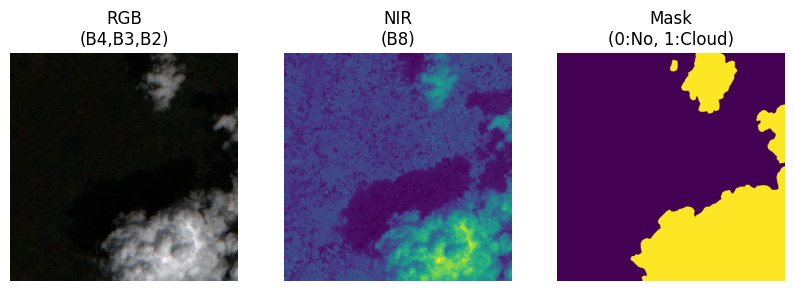

In [8]:
idxs = np.random.randint(0, len(train_dataset)-1, 1)

for i, idx in enumerate(idxs):
    print(train_dataset.metadata.loc[idx,'chip_id'])
    train_dataset.plot(train_dataset[idx])

phlj


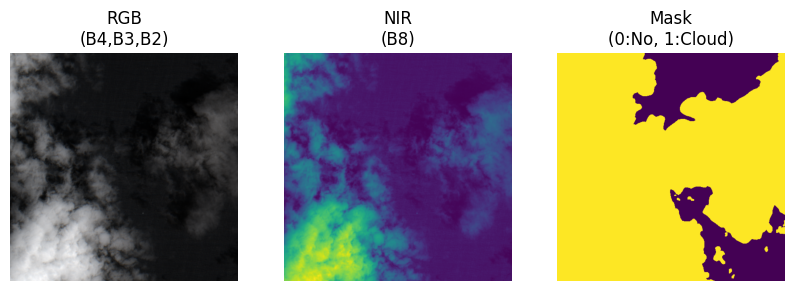

In [9]:
idxs = np.random.randint(0, len(val_dataset)-1, 1)

for i, idx in enumerate(idxs):
    print(val_dataset.metadata.loc[idx,'chip_id'])
    val_dataset.plot(val_dataset[idx])

scbq


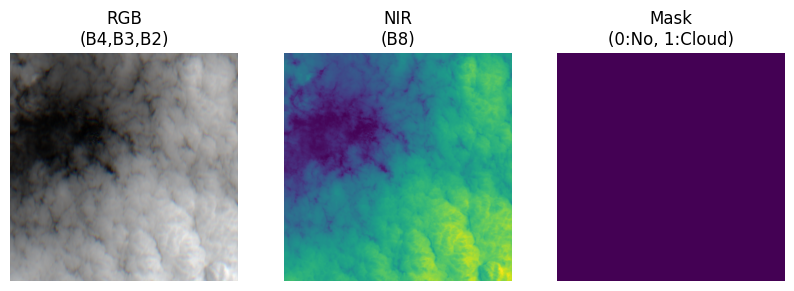

In [10]:
idxs = np.random.randint(0, len(test_dataset)-1, 1)

for i, idx in enumerate(idxs):
    print(test_dataset.metadata.loc[idx,'chip_id'])
    test_dataset.plot(test_dataset[idx])

In [12]:
from terratorch.datamodules import TorchNonGeoDataModule
from torchgeo.datamodules import NonGeoDataModule
import albumentations as A
from albumentations.pytorch import ToTensorV2

datamodule = TorchNonGeoDataModule(

    # Dataset Module
    cls = NonGeoDataModule,
    batch_size = 16,
    num_workers = 0,

    # Dataset
    dataset_class = CustomCloudCoverDetection,
    root = './dataset',
    # split = 'train',
    transforms=[A.Normalize(normalization='min_max_per_channel'), ToTensorV2()],
    download=False
)

# Lightning Trainers

How to set validation set?

In [13]:
from terratorch.tasks import SemanticSegmentationTask
from library.analysis import CustomSemanticSegmentationTask

model_args = {
        "backbone":"resnet50", # see smp_encoders.keys()
        'model': 'Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus'
        "bands": bands,
        "in_channels": 4,
        "num_classes": 2,
        "pretrained": True,
}

task = SemanticSegmentationTask(
    model_args=model_args,
    model_factory="SMPModelFactory",
    loss="dice",
    lr=1e-4,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
    class_names=['No', 'Cloud'],
    plot_on_val=0,
)

In [15]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='tutorial')

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=25, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
_ = trainer.fit(model=task, datamodule=datamodule)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ SMPModelWrapper  │ 32.5 M │ train │
│ 1 │ criterion     │ DiceLoss         │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 9.0 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 254                                                                                         
Modules in eval mode: 0

Output()

In [ ]:
res = trainer.test(model=task, datamodule=datamodule)

In [ ]:
# Analyze training in tensorboard
!tensorboard --logdir output/ --port 9010  # add --host $(hostname -f) for clusters

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.17.1 at http://Thornhill:9010/ (Press CTRL+C to quit)
^C


# CLI tool

You find an example for SMP models in `configs/burnscars_smp.yaml` that you can run with `terratorch fit -c configs/burnscars_smp.yaml`.